# Thorough Gridsearch Model


This notebook contains code to easily add a model and preprocessor(s) and gridsearch through every possible combination to find the best

---

In [130]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold

import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from pprint import pprint
from xgboost import XGBClassifier
import joblib


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
from helpers import load_sqlite, custom_stop_words, get_random_class_labels, plot_confusion_matrix

In [132]:
random_state = 77

# labels = ['python','aws','datascience','machinelearning','dataengineering']
# list to get data for
labels = get_random_class_labels(3)
print(labels)

df = load_sqlite(database='reddit.sqlite', class_labels=labels)

# what we expected?
df.sample(10)

['softwarearchitecture' 'aws' 'tensorflow']


,title,subreddit,date
890,Unusual audio recognition - how to get started?,tensorflow,2020-03-29
1703,AWS Account Structure Best Practices,aws,2020-03-29
797,NVIDIA Jetson Nano Developer Kit,tensorflow,2020-03-29
47844,Lintly (GitHub PR code reviewer for Cloudforma...,aws,2020-05-09
82128,What is the safest way to create Authenticator ?,aws,2020-05-20
2145,An Insight Into How Uber Scaled From A Monolit...,softwarearchitecture,2020-03-29
9617,AWS VPN for aditional VPC,aws,2020-04-14
1184,Looking to build a scheduling service for spre...,aws,2020-03-29
3835,Is aws safe?,aws,2020-04-02
1370,Is it possible to enforce a smaller max payloa...,aws,2020-03-29


In [133]:
X = df['title']
y = df['subreddit']

In [134]:
labeler = LabelEncoder()
y = labeler.fit_transform(y)
y.shape

(5406,)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [136]:
y_test.shape



(1352,)

In [137]:
tfidf = {
    'preprocessor': TfidfVectorizer(stop_words=custom_stop_words),
    'params': {
        "prep__ngram_range": [(1, 2)],
        "prep__max_df": [.9],
        "prep__use_idf": [True],
        "prep__norm": ["l2"]
    }
}

In [160]:
estimators = {
    # "logisticregression": {
    #     "name": "Logistic Regression",
    #     "estimator": LogisticRegression(max_iter=1000, fit_intercept=False, C=.99),
    #     "params": {
    #         "clf__solver": ["lbfgs", "saga"]
    #     }
    # },
    # "randomforestclassifier": {
    #     "name": "Random Forest",
    #     "estimator": RandomForestClassifier(min_samples_leaf=2, min_samples_split=.01),
    #     "params": {
    #         "clf__n_estimators": [300, 500, 1000],
    #         "clf__max_depth": np.linspace(400, 1000, 5, dtype=int)
    #     }
    # },
  
    # "multinomialnb": {
    #     "name": "Multinomial Bayes Classifier",
    #     "estimator": MultinomialNB(alpha=.1189),
    #     "params": {
    #         "clf__fit_prior": [True, False]
    #     }
    # },
    # "svc": {
    #     "name": "Support Vector Classifier",
    #     "estimator": SVC(kernel="sigmoid"),
    #     "params": {
    #         "clf__C": [.99, 1]
    #     }
    # },
    # "sgdclassifier": {
    #     "name": "Stochastic Gradient Descent Classifier",
    #     "estimator": SGDClassifier(alpha=.0001, fit_intercept=True, penalty="l2"),
    #     "params":
    #         {
    #     }
    # },
    'xgbclassifier': {
        'name': 'XGBoost Classifier',
        'estimator': XGBClassifier(n_estimators=200),
        'params': {
            "clf__max_depth": [3, 5, 10],
            "clf__learning_rate": np.linspace(.001, .1, 3),
            "clf__n_estimators": [50, 100, 200],
            "clf__objective": ['binary:logistic', 'multi:softprob'],
            "clf__booster": ['gbtree', 'gblinear', 'dart'],
            "clf__gamma": np.linspace(0, 1, 3),
            "clf__subsample": [.5, 1],
            "clf__reg_lambda": np.linspace(0, 1, 3),
        }
    }
}

In [161]:
def build_and_train_model(preprocessor, classifier, cv=3, verbose=1):
    '''
    Takes a dictionary with params and outputs a fitted model
    '''
    pipe = Pipeline(
    [('prep', preprocessor.get('preprocessor')),
     ('clf', classifier.get('estimator'))])
    
    pipe_params = dict()
    pipe_params.update(preprocessor.get('params'))
    pipe_params.update(classifier.get('params'))
    
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    model = GridSearchCV(pipe, param_grid=pipe_params, cv=skf, verbose=verbose, n_jobs=-1)
    model.fit(X_train, y_train)
    return model

**************************************************
Model: Logistic Regression

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    1.7s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.8s finished

Train Score: 0.982486433152442
Test Score: 0.852810650887574
AUC Score: 0.949842457771533

              precision    recall  f1-score   support

           0      0.848     0.946     0.894       764
           1      0.863     0.689     0.766       264
           2      0.861     0.765     0.810       324

    accuracy                          0.853      1352
   macro avg      0.857     0.800     0.824      1352
weighted avg      0.854     0.853     0.849      1352



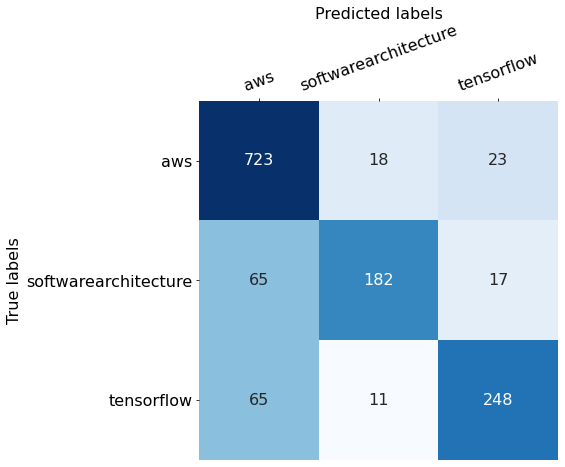



**************************************************
Model: Random Forest

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  45 | elapsed:   19.9s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:   24.9s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   27.0s finished

Train Score: 0.8909718796250616
Test Score: 0.8143491124260355
AUC Score: 0.9312669127662746

              precision    recall  f1-score   support

           0      0.793     0.945     0.862       764
           1      0.897     0.595     0.715       264
           2      0.835     0.685     0.753       324

    accuracy                          0.814      1352
   macro avg      0.841     0.742     0.777      1352
weighted avg      0.823     0.814     0.807      1352



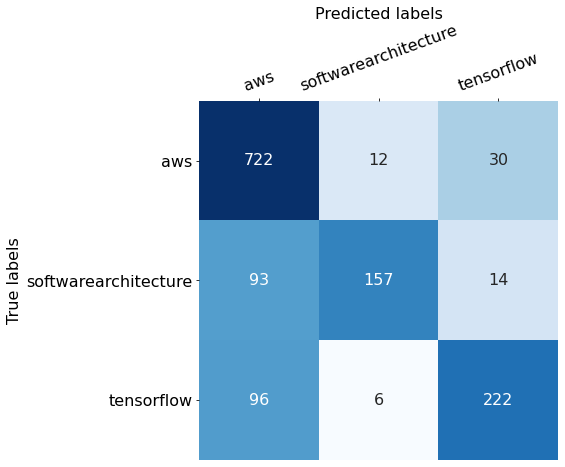



**************************************************
Model: Multinomial Bayes Classifier

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished

Train Score: 0.9938332511100147
Test Score: 0.8653846153846154
AUC Score: 0.9581247726337526

              precision    recall  f1-score   support

           0      0.913     0.897     0.905       764
           1      0.747     0.814     0.779       264
           2      0.860     0.833     0.846       324

    accuracy                          0.865      1352
   macro avg      0.840     0.848     0.843      1352
weighted avg      0.868     0.865     0.866      1352



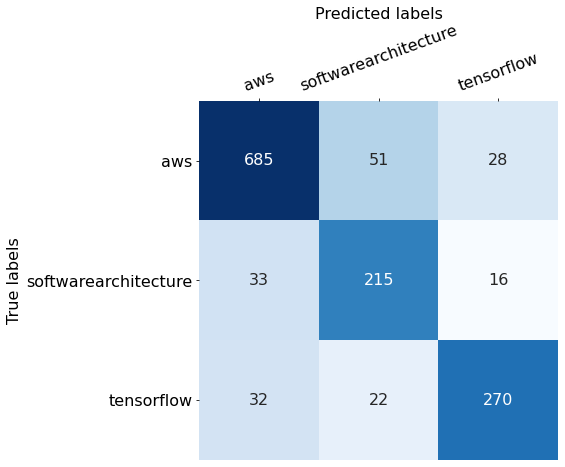



**************************************************
Model: Support Vector Classifier

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.1s finished

Train Score: 0.96250616674889
Test Score: 0.8557692307692307

              precision    recall  f1-score   support

           0      0.831     0.963     0.892       764
           1      0.908     0.670     0.771       264
           2      0.900     0.753     0.820       324

    accuracy                          0.856      1352
   macro avg      0.880     0.796     0.828      1352
weighted avg      0.862     0.856     0.851      1352



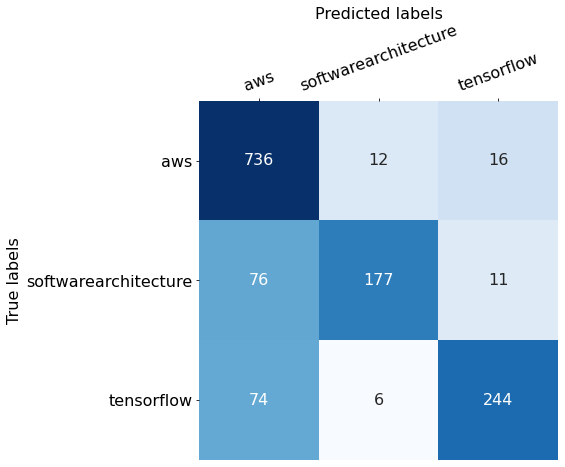



**************************************************
Model: Stochastic Gradient Descent Classifier

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished

Train Score: 0.998766650222003
Test Score: 0.8624260355029586

              precision    recall  f1-score   support

           0      0.868     0.935     0.900       764
           1      0.866     0.735     0.795       264
           2      0.846     0.796     0.820       324

    accuracy                          0.862      1352
   macro avg      0.860     0.822     0.838      1352
weighted avg      0.862     0.862     0.860      1352



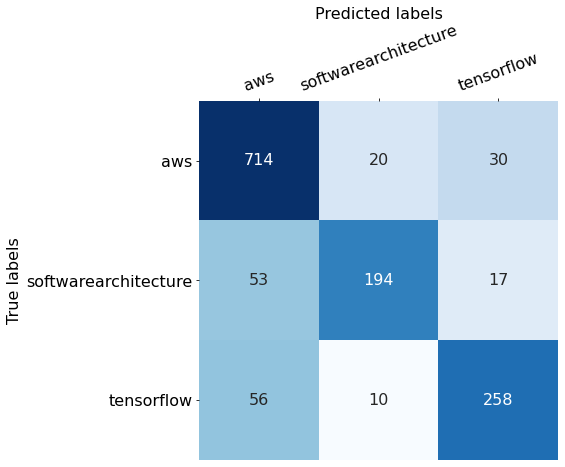



**************************************************
Model: XGBoost Classifier

Fitting 3 folds for each of 7031250 candidates, totalling 21093750 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   32.3s


KeyboardInterrupt: 

In [159]:
for name, estimator in estimators.items():
    print("*"*50)
    print(f'Model: {estimator.get("name")}')
    print()
    model = build_and_train_model(preprocessor=tfidf, classifier=estimator, cv=3, verbose=5)
    
    date = str(datetime.datetime.now().strftime('%Y-%m-%d_%H%M'))
    estimator_name = type(model.estimator.named_steps.clf).__name__
    # joblib_file = f'{estimator_name}_best_model_{date}.pkl'
    # joblib.dump(model, CONFIG.DATA_DIR / joblib_file)
    print()
    print(f'Train Score: {model.score(X_train, y_train)}')
    print(f'Test Score: {model.score(X_test, y_test)}')
    
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)
        print(f'AUC Score: {roc_auc_score(y_test, y_proba, multi_class="ovr")}')
    print()    
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))

    plot_confusion_matrix(model, y_test, y_pred, classes=labeler.classes_)
    # plt.savefig(CONFIG.DATA_DIR / f'{estimator_name}_confusion_matrix_{date}.png')
    plt.show()
    print()
    print()